In [1]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks")

%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(11, 9)

In [4]:
### Collect data
url_confirmed = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_confirmed_global.csv&filename=time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_confirmed)

url_deaths = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_deaths_global.csv&filename=time_series_covid19_deaths_global.csv'
deaths = pd.read_csv(url_deaths)

url_recovered = 'https://data.humdata.org/hxlproxy/api/data-preview.csv?url=https%3A%2F%2Fraw.githubusercontent.com%2FCSSEGISandData%2FCOVID-19%2Fmaster%2Fcsse_covid_19_data%2Fcsse_covid_19_time_series%2Ftime_series_covid19_recovered_global.csv&filename=time_series_covid19_recovered_global.csv'
recovered = pd.read_csv(url_recovered)

In [5]:
print('confirmed shape', confirmed.shape)
print('deaths shape', deaths.shape)
print('recovered shape', recovered.shape)
date_cols = deaths.columns[4:]

confirmed shape (263, 80)
deaths shape (263, 80)
recovered shape (249, 80)


In [6]:
deaths['Country/Region'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Brazil', 'Brunei', 'Bulgaria',
       'Burkina Faso', 'Cabo Verde', 'Cambodia', 'Cameroon', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Congo (Brazzaville)', 'Congo (Kinshasa)', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Diamond Princess', 'Cuba', 'Cyprus',
       'Czechia', 'Denmark', 'Djibouti', 'Dominican Republic', 'Ecuador',
       'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece', 'Guatemala',
       'Guinea', 'Guyana', 'Haiti', 'Holy See', 'Honduras', 'Hungary',
       'Iceland', 'India

In [15]:
def metrics(country, metric):
    if metric == 'deaths':
        return deaths[deaths['Country/Region'] == country][date_cols].sum()
    if metric == 'confirmed':
        return confirmed[confirmed['Country/Region'] == country][date_cols].sum()
    if metric == 'recovered':
        return recovered[recovered['Country/Region'] == country][date_cols].sum()
    else:
        d = deaths[deaths['Country/Region'] == country][date_cols].sum()
        c = confirmed[confirmed['Country/Region'] == country][date_cols].sum()
        return d/c

def metrics_plt(countries,m):
    for country in countries:
        metrics(country,m).plot(label=country)
    plt.legend()
    plt.title(m)

In [16]:
def grads(country, metric):
    if metric == 'deaths':
        a = deaths[deaths['Country/Region'] == country][date_cols].sum()
        return pd.Series(np.ndarray.flatten(np.gradient(a)), index = date_cols)
    if metric == 'confirmed':
        a = confirmed[confirmed['Country/Region'] == country][date_cols].sum()
        return pd.Series(np.ndarray.flatten(np.gradient(a)), index = date_cols)
    if metric == 'recovered':
        a = recovered[recovered['Country/Region'] == country][date_cols].sum()
        return pd.Series(np.ndarray.flatten(np.gradient(a)), index = date_cols)
    else:
        d = deaths[deaths['Country/Region'] == country][date_cols].sum()
        c = confirmed[confirmed['Country/Region'] == country][date_cols].sum()
        return pd.Series(np.ndarray.flatten(np.gradient(d/c)), index = date_cols)

def grads_plt(countries,m):
    for country in countries:
        a = grads(country,m)
        a.plot(label=country)
        plt.legend()
        plt.title(m)

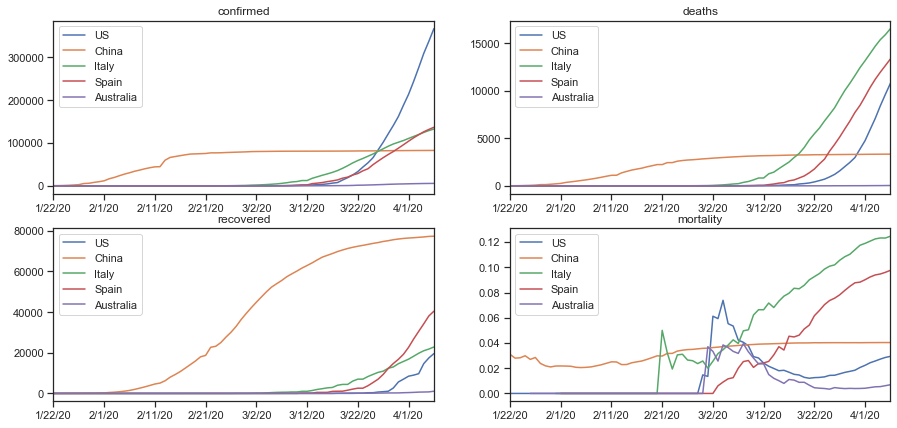

In [20]:
countries = ['US','China','Italy', 'Spain','Australia']
metrics_list = ['confirmed', 'deaths', 'recovered', 'mortality']

figsize(15, 7)
for k, m in enumerate(metrics_list):
    sx = plt.subplot(2, 2, k+1)
    plt.setp(sx.get_yticklabels(), visible=True)
    metrics_plt(countries,m)

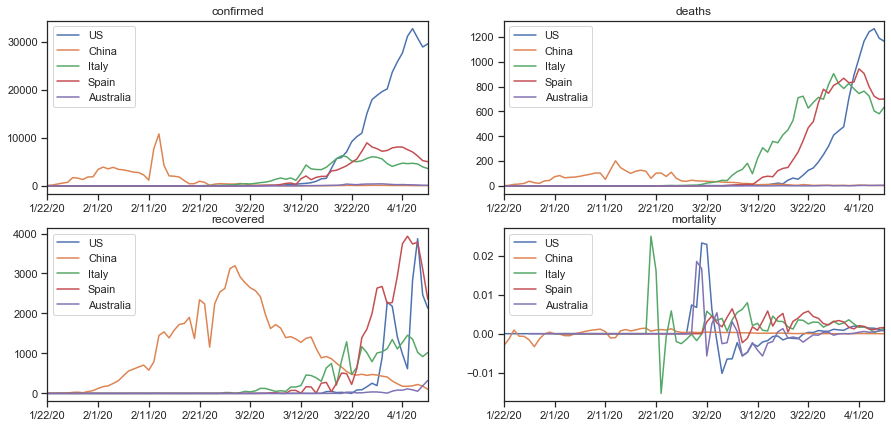

In [21]:
## Gradients
figsize(15, 7)
for k, m in enumerate(metrics_list):
    sx = plt.subplot(2, 2, k+1)
    plt.setp(sx.get_yticklabels(), visible=True)
    grads_plt(countries,m)